In [1]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_column', 200)

In [2]:
gdf = gpd.read_file("clean_data/master.shp")

## Purpose

Our purpose is to understand the effects of the `concentration grant` on academic performance. 

## <s>Structure</s> (outdated)
The general structure of the dataset is as follows:

- **county**<br>
    
_58 in the state - top level deliniator._
    
    
- county    
    - **school district**<br>
    
_Within each county, a number of school districts. We have demographic profiles of each district that we can use in the matching process, if applicable._
    
    
- county    
    - school district    
        - **student group**<br>
        
_Further, the grade data breaks down into 17 student groups per district. Using this we can query academic performance by a specific group._
        
        
- county    
    - school district    
        - student group
            - **math grades**
            - **english grades**<br>
            
_Finally, the specific math and english grades lie at the bottom of the data structure._ 

In [3]:
#gdf

## Conflicting data

A key indicator for defining classes of school districts is the Unduplicated Pupil Count (UPC), the share of students which qualify as high needs as defined under California SB-97. Because it is a key indicator, two data sources include it. Unfortunately, the two sources provide different values for the same indicator. `UPpct` is the UPC as defined by the attributes dataset. From the source [website](https://gis.data.ca.gov/datasets/e9476c422f0842a7a38652aaf4c7597c_0?geometry=-146.710%2C31.049%2C-91.295%2C43.258):

> Boundary lines are maintained by the California Department of Education (CDE) and are effective in the 2018-19 academic year . The CDE works collaboratively with the US Census Bureau to update and maintain boundary information as part of the federal School District Review Program (SDRP). 

The second variable, `unduplicat` comes from the [LCFF funding snapshot](https://ias.cde.ca.gov/lcffsnapshot/lcff.aspx), which is less recent, without the collaboration of the census, and lacks the polish that the collaboration brought. 

Our issue is that `UPpct` and `unduplicat` are different values, despite representing the same variable. 

Let's investigate the depths of the differences between the two attributes.

In [4]:
gdf.UPpct

0      0.335
1      0.304
2      0.334
3      0.296
4      0.831
       ...  
939    0.812
940    0.816
941    0.387
942    0.486
943    0.446
Name: UPpct, Length: 944, dtype: float64

In [5]:
gdf.unduplicat

0      0.3486
1      0.2833
2      0.3519
3      0.2904
4      0.7953
        ...  
939    0.6988
940    0.8168
941    0.3868
942    0.4783
943    0.4283
Name: unduplicat, Length: 944, dtype: float64

In [6]:
gdf['UPdiff'] = gdf['UPpct'] - gdf['unduplicat']
print(gdf['UPdiff'])

0     -0.0136
1      0.0207
2     -0.0179
3      0.0056
4      0.0357
        ...  
939    0.1132
940   -0.0008
941    0.0002
942    0.0077
943    0.0177
Name: UPdiff, Length: 944, dtype: float64


In [7]:
pd.Series.mean(gdf['UPdiff'])

0.006848198789358151

In [8]:
pd.Series.median(gdf['UPdiff'])

0.004999992370605499

On average, the difference between `UPpct` and `unduplicat` are very small. What about any extreme values?

In [9]:
pd.Series.max(gdf['UPdiff'])

0.4074

this is kind of large, let's use the `shape` function to call a tuple indicating `(Nrows, NCollumns)` of the sliced dataframe.

In [10]:
gdf.loc[gdf['UPdiff'] > 0.05].shape
# number of districts where the difference is larger than 0.05. 

(68, 183)

In [11]:
gdf.loc[gdf['UPdiff'] > 0.1].shape
# number of districts where the difference is larger than 0.1.

(17, 183)

In [12]:
gdf.loc[gdf['UPdiff'] > 0.2].shape
# number of districts where the difference is larger than 0.2.

(1, 183)

This gives us an idea of the extent of the conflicting data on this variable. 

## Visual exploration

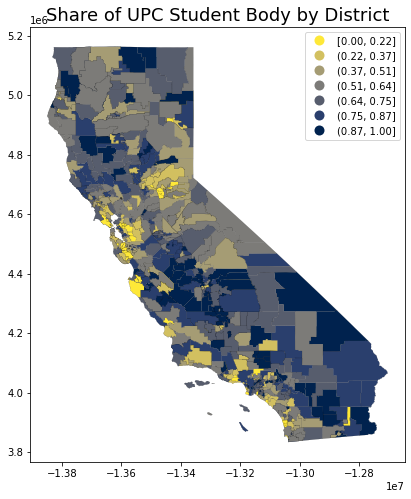

In [13]:
f, ax = plt.subplots(figsize  = (12, 8))

ax.set_title("Share of UPC Student Body by District", fontsize=18)

gdf.plot(
    column='UPpct',
    legend=True,
    figsize=(15, 15),
    scheme="fisher_jenks", # 7 class fisher_jenks classification
    k=7,
    linewidth=.1,
    edgecolor='black',
    cmap='cividis_r',
    ax=ax
        )

The classification scheme impacts the visualization. Rather than using a standardized scheme, it might make more sense to use a user-defined classification to better distinguish districts that recieve concentration grants from districts that do not. That determining factor is the `unduplicated pupil count` or *UPC* of students which are disadvantaged in at least one of a few defined ways. A share of UPC of 0.55 or higher means that the district recieves a concentration grant. 

A user-defined classification to capture the cutoff for reciept of a concentration grant might look like this:
- 0 -> 0.10
- 0.10 -> 0.25
- 0.25 -> 0.5499
- 0.55 -> 0.70
- 0.70 -> 1.0

In [14]:
x = (gdf['UPpct'])
# setting variable of interest
bins_list = [0.10, 0.25, 0.5499, 0.7, 1]
# setting bins
cm = plt.cm.cividis_r
# seting colormap

In [15]:
from legendgram import legendgram
import palettable.matplotlib as palmpl

(0.0, 1.0, 0.0, 1.0)

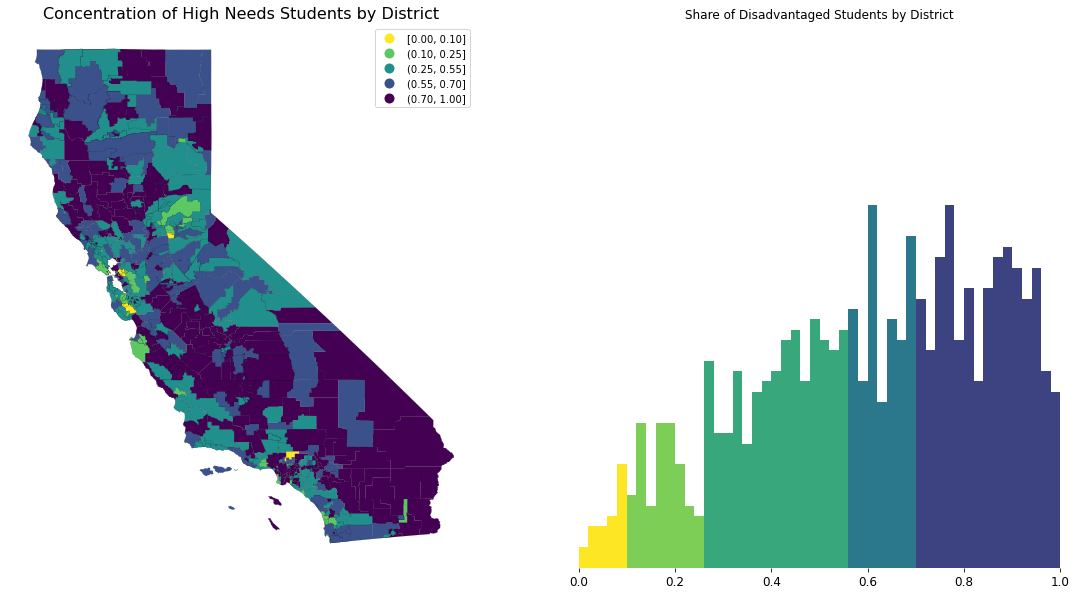

In [16]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(19,10))

plt.title('Share of Disadvantaged Students by District')

gdf.plot(
    column='UPpct',
    legend=True,
    scheme='userdefined',
    classification_kwds={'bins':bins_list},
    linewidth=.1,
    edgecolor='black',
    cmap='viridis_r',
    ax=ax1
        )
ax1.set_title("Concentration of High Needs Students by District", fontsize=16)
# title for map

legendgram(f,ax2,x.values,bins_list,pal=palmpl.Viridis_5_r,
               legend_size=(1,.7), # legend size in fractions of the axis
               loc = 'lower left', # matplotlib-style legend locations
               clip = (0,1) # clip the displayed range of the histogram
               )

ax1.axis("off")
ax2.axis("off")

- What are the demographic makeups of each bin?

the darker polygons indicate a higher share of UPC, while the lighter districts have a lesser concentration of disadvantaged students. What happens if we further divide the top bin, the districts with the smallest share of UPC?

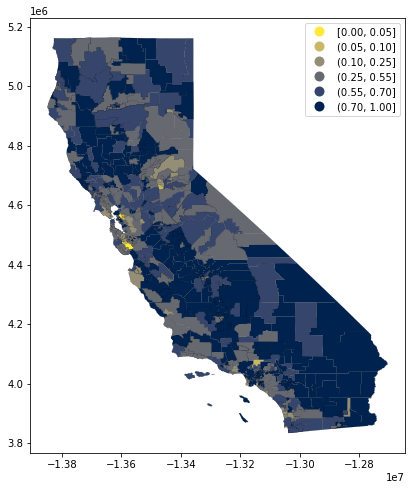

In [17]:
f, ax = plt.subplots(figsize=(12, 8))

gdf.plot(
    column='UPpct',
    legend=True,
    figsize=(15, 15),
    scheme='userdefined',
    classification_kwds={'bins':[0.05, 0.1, 0.25, 0.5499, 0.7, 1]},
    linewidth=.1,
    edgecolor='black',
    cmap='cividis_r',
    ax=ax
        )

This reveals that there are fewer highly priviledged/homogenized districts than the previous visualization led us to believe, but there are still some. It looks like the marjority of priviledged districts are somwhere between the `0.1` and `0.25` range of UPC.

Now lets put the original Fisher Jenks classification next to our user-defined 4-bin classification scheme.

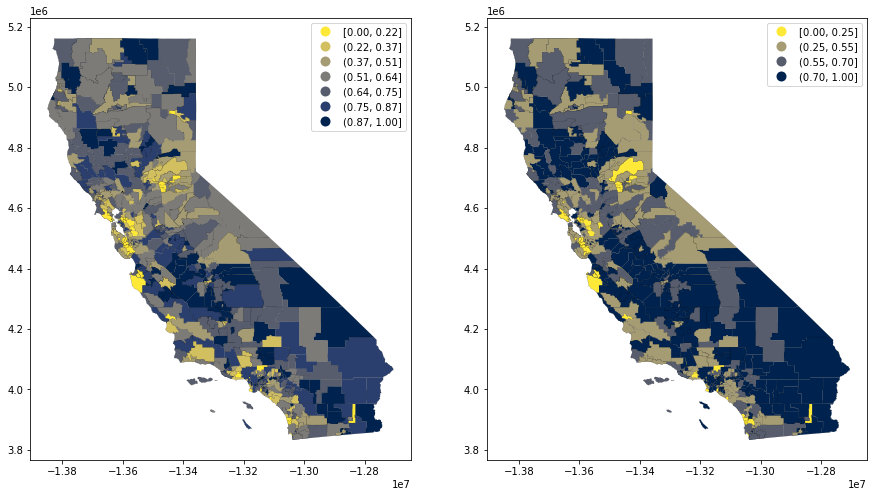

In [18]:
f, ax = plt.subplots(ncols=2, figsize=(15, 15))
#two plots breaks title

gdf.plot(
    column='UPpct',
    legend=True,
    figsize=(15, 15),
    scheme="fisher_jenks",
    k=7,
    linewidth=.1,
    edgecolor='black',
    cmap='cividis_r',
    ax=ax[0]
        )

gdf.plot(
    column='UPpct',
    legend=True,
    figsize=(15, 15),
    scheme='userdefined',
    classification_kwds={'bins':[0.25, 0.5499, 0.7, 1]},
    linewidth=.1,
    edgecolor='black',
    cmap='cividis_r',
    ax=ax[1]
        )
# ax.set_title("Share of UPC Concentration, Fisher Jenks vs User Defined Classes")
# two plots side by side PogU

## adding county boundaries

[link to source](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-county-boundaries?geometry=-146.710%2C31.049%2C-91.295%2C43.258)

[geopandas docs](https://geopandas.org/mapping.html)

Not sure if we need to merge these into the gdf or if it's possible, We might just keep the county boundaries for visualization purposes. 

In [19]:
counties = gpd.read_file("raw_data/cnty19_1.shp")

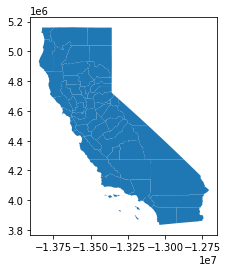

In [20]:
counties.plot()

In [21]:
counties.head()

,OBJECTID,COUNTY_NAM,COUNTY_ABB,COUNTY_NUM,COUNTY_COD,COUNTY_FIP,ISLAND,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
0,1,Alameda,ALA,1,01,001,None,{E6F92268-D2DD-4CFB-8B79-5B4B2F07C559},308998.650975,3.402787e+09,"POLYGON ((-13611173.233 4566017.932, -13611061..."
1,2,Alpine,ALP,2,02,003,None,{870479B2-480A-494B-8352-AD60578839C1},274888.492662,3.146939e+09,"POLYGON ((-13312326.921 4680816.110, -13312311..."
2,3,Amador,AMA,3,03,005,None,{4F45B3A6-BE10-461C-8945-6B2AAA7119F6},361708.438649,2.562635e+09,"POLYGON ((-13366405.546 4679183.529, -13366408..."
3,4,Butte,BUT,4,04,007,None,{44FBA680-AECC-4E04-A499-29D69AFFBD4A},526547.113134,7.339348e+09,"POLYGON ((-13478186.664 4807593.081, -13478502..."
4,5,Calaveras,CAL,5,05,009,None,{D11EF739-4A1E-414E-BFD1-E7DCD56CD61E},370637.579039,4.351069e+09,"POLYGON ((-13360333.217 4641182.754, -13360329..."


In [22]:
counties['geometry'].crs
# thankfully the same as our dataset 

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
gdf['geometry'].crs
# see, I told you

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

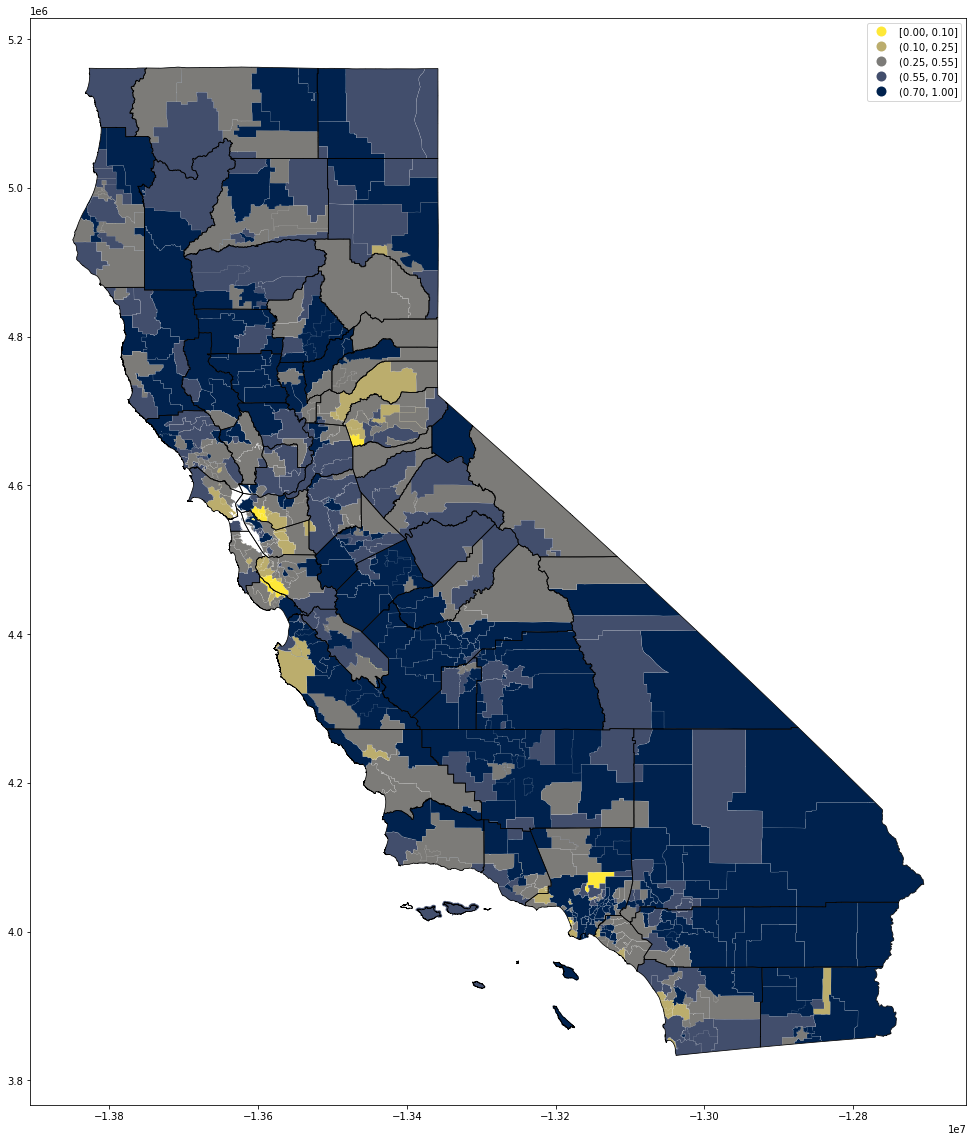

In [24]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')

gdf.plot(column='UPpct',
        legend=True,
        scheme='userdefined',
        classification_kwds={'bins':bins_list},
        linewidth=.1,
        edgecolor='white',
        cmap='cividis_r',
        ax=ax)

counties.boundary.plot(facecolor='none',
                       edgecolor='black',
                       linewidth=.75,
                       ax=ax)

# that was easy, actually

Attempting to merge 

In [25]:
overlay = pd.merge(gdf, counties, left_on='CountyName', right_on='COUNTY_NAM', how='left') 

In [26]:
overlay.head()

,index,OBJECTID_x,Year,FedID,CDCode,CDSCode,CountyName,DistrictNa,DistrictTy,GradeLow,GradeHigh,GradeLowCe,GradeHighC,AssistStat,CongressUS,SenateCA,AssemblyCA,LocaleDist,UpdateNote,EnrollTota,EnrollChar,EnrollNonC,AAcount,AApct,AIcount,AIpct,AScount,ASpct,FIcount,FIpct,HIcount,HIpct,MRcount,MRpct,PIcount,PIpct,WHcount,WHpct,NRcount,NRpct,ELcount,ELpct,FOScount,FOSpct,HOMcount,HOMpct,MIGcount,MIGpct,SWDcount,SWDpct,SEDcount,SEDpct,UPcount,UPpct,ELATested,ELAStdMetP,MathTested,MathStdMet,CCPrepCoho,CCPrepPct,AbsentElig,AbsentPct,GradCohort,GradPct,UCCSUReqMe,DropOutPct,EnrollCumu,SuspPct,SHAPE_Leng_x,SHAPE_Area_x,Unnamed__0,district_1,unduplicat,base_grant,supplement,concentrat,total_gran,cds,District_C,e_chan_AA,e_chan_AI,e_chan_ALL,e_chan_AS,e_chan_EL,e_chan_ELO,e_chan_EO,e_chan_FI,e_chan_FOS,e_chan_HI,e_chan_HOM,e_chan_MR,e_chan_PI,e_chan_RFP,e_chan_SED,e_chan_SWD,e_chan_WH,e_curr_AA,e_curr_AI,e_curr_ALL,e_curr_AS,e_curr_EL,e_curr_ELO,e_curr_EO,e_curr_FI,e_curr_FOS,e_curr_HI,e_curr_HOM,e_curr_MR,e_curr_PI,e_curr_RFP,e_curr_SED,e_curr_SWD,e_curr_WH,e_prio_AA,e_prio_AI,e_prio_ALL,e_prio_AS,e_prio_EL,e_prio_ELO,e_prio_EO,e_prio_FI,e_prio_FOS,e_prio_HI,e_prio_HOM,e_prio_MR,e_prio_PI,e_prio_RFP,e_prio_SED,e_prio_SWD,e_prio_WH,m_chan_AA,m_chan_AI,m_chan_ALL,m_chan_AS,m_chan_EL,m_chan_ELO,m_chan_EO,m_chan_FI,m_chan_FOS,m_chan_HI,m_chan_HOM,m_chan_MR,m_chan_PI,m_chan_RFP,m_chan_SED,m_chan_SWD,m_chan_WH,m_curr_AA,m_curr_AI,m_curr_ALL,m_curr_AS,m_curr_EL,m_curr_ELO,m_curr_EO,m_curr_FI,m_curr_FOS,m_curr_HI,m_curr_HOM,m_curr_MR,m_curr_PI,m_curr_RFP,m_curr_SED,m_curr_SWD,m_curr_WH,m_prio_AA,m_prio_AI,m_prio_ALL,m_prio_AS,m_prio_EL,m_prio_ELO,m_prio_EO,m_prio_FI,m_prio_FOS,m_prio_HI,m_prio_HOM,m_prio_MR,m_prio_PI,m_prio_RFP,m_prio_SED,m_prio_SWD,m_prio_WH,geometry_x,UPdiff,OBJECTID_y,COUNTY_NAM,COUNTY_ABB,COUNTY_NUM,COUNTY_COD,COUNTY_FIP,ISLAND,GlobalID,SHAPE_Leng_y,SHAPE_Area_y,geometry_y
0,NaN,1,2018-19,0601770,0161119,1611190000000,Alameda,Alameda Unified,Unified,KG,12,KG,12,Differentiated Assistance,13,09,18,"21 - Suburban, Large",2018-19 District Boundary Adjustment/Correction,11260,1877,9383,825,7.300000,28,0.2,2854,25.299999,683,6.1,1960,17.400000,1310,11.6,67,0.6,3244,28.799999,289,2.6,1601,14.2,26,0.2,67,0.6,0,0.0,1289,11.4,3523,31.299999,3144,0.335,4567.0,69.400002,4587.0,59.700001,773.0,56.799999,11453.0,9.4,882.0,88.900002,58.900002,5.2,11600.0,2.6,57196.403944,4.733304e+07,10,Alameda Unified,0.3486,"75,938,983","5,294,466",-,"82,158,116",1.611190e+12,11190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-13606221.352 4540862.002, -13...",-0.0136,1,Alameda,ALA,1,01,001,None,{E6F92268-D2DD-4CFB-8B79-5B4B2F07C559},308998.650975,3.402787e+09,"POLYGON ((-13611173.233 4566017.932, -13611061..."
1,NaN,2,2018-19,0601860,0161127,1611270000000,Alameda,Albany City Unified,Unified,KG,12,KG,12,General Assistance,13,09,15,"21 - Suburban, Large",2018-19 District Boundary Adjustment/Correction,3682,0,3682,111,3.000000,4,0.1,1063,28.900000,47,1.3,592,16.100000,510,13.9,6,0.2,1163,31.600000,186,5.1,583,15.8,2,0.1,12,0.3,0,0.0,312,8.5,777,21.100000,1118,0.304,1773.0,79.199997,1795.0,72.000000,302.0,62.599998,3763.0,6.4,301.0,94.699997,63.900002,1.7,3830.0,1.9,12870.772156,7.161276e+06,16,Albany City Unified,0.2833,"29,644,972","1,679,684",-,"31,352,540",1.611270e+12,11270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [27]:
overlay = overlay.set_geometry('geometry_x')
# can we have two geometry columns set? Does this give any advantage beyond being able to load all of the data in one file?

So the merge works, but it might be redundant because I would need to find a way to plot two geometry columns on one plt, the result would be the same as if the gdfs remained unmerged.

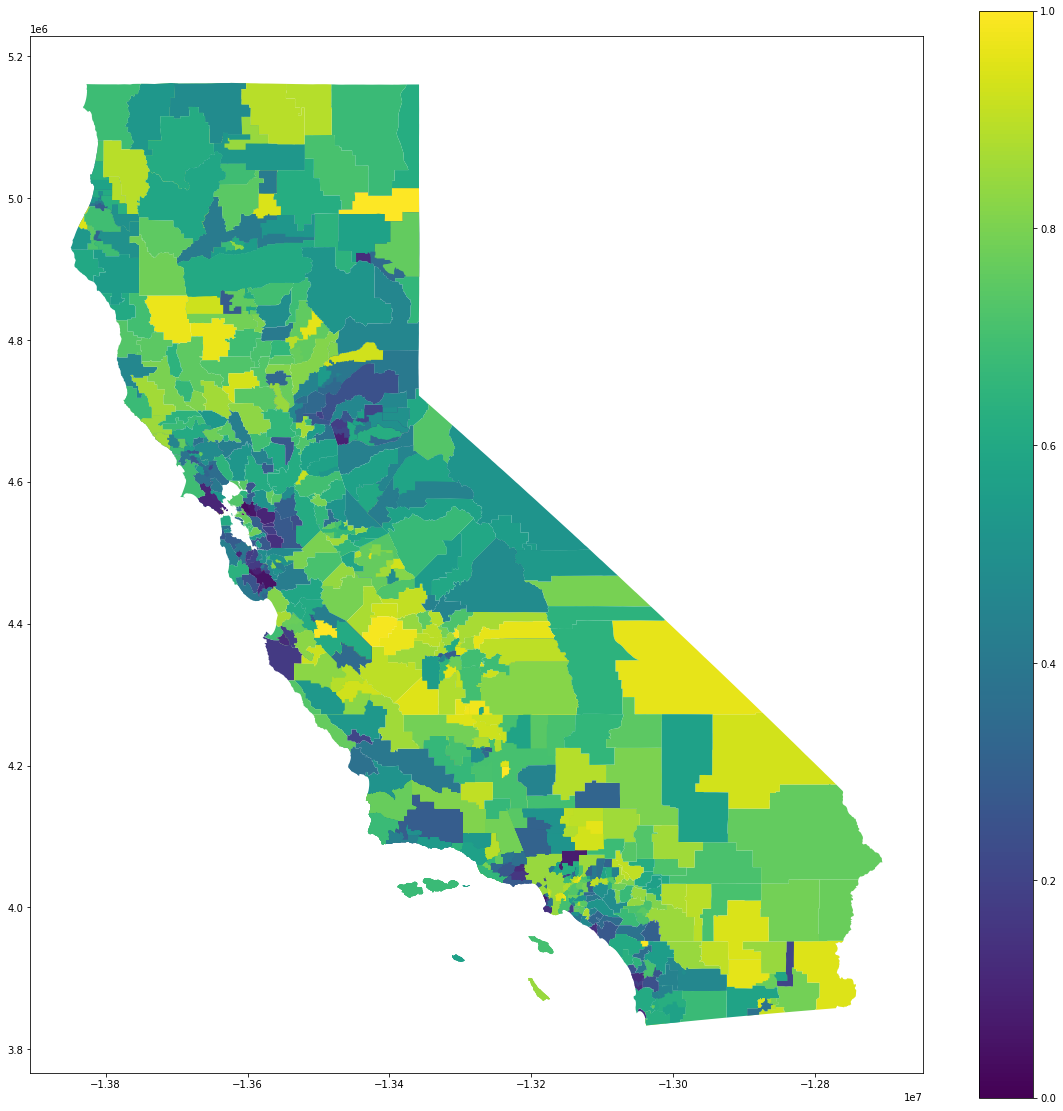

In [28]:
overlay.plot(figsize=(20,20), legend=True, column='UPpct')